**About** : This notebook is used to train models.


In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/Documents/sartorius/src


## Initialization

### Imports

In [3]:
import os
import sys
import cv2
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import plot_sample

from data.preparation import prepare_data
from data.transforms import get_transfos, get_transfos_inference
from data.dataset import SartoriusDataset

from training.main import k_fold

In [5]:
from data.transforms import get_transfos
from data.dataset import SartoriusDataset

from utils.rle import rles_to_mask, rles_to_mask_fix

## Data

In [6]:
df = prepare_data(width=1)

In [7]:
idx = 20
mask_ref = rles_to_mask_fix(df['annotation'][idx], shape=df[['height', 'width']].values[idx])


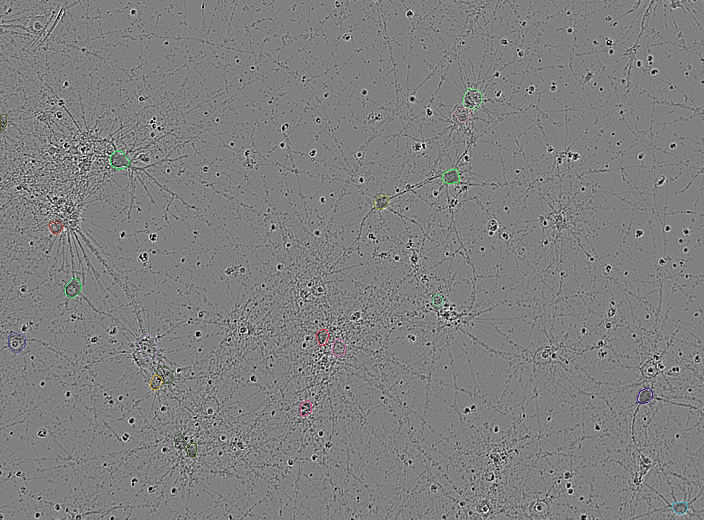

In [8]:
idx = 10

dataset_plot = SartoriusDataset(df)
img, masks = dataset_plot[idx]


mask = masks[..., 0]
fig = plot_sample(img, mask, plotly=True)

fig.update_layout(
    autosize=False,
    width=900,
    height=800,
)

fig.show()

In [9]:
transforms = get_transfos(augment=True, visualize=True)
dataset = SartoriusDataset(df, transforms=transforms)

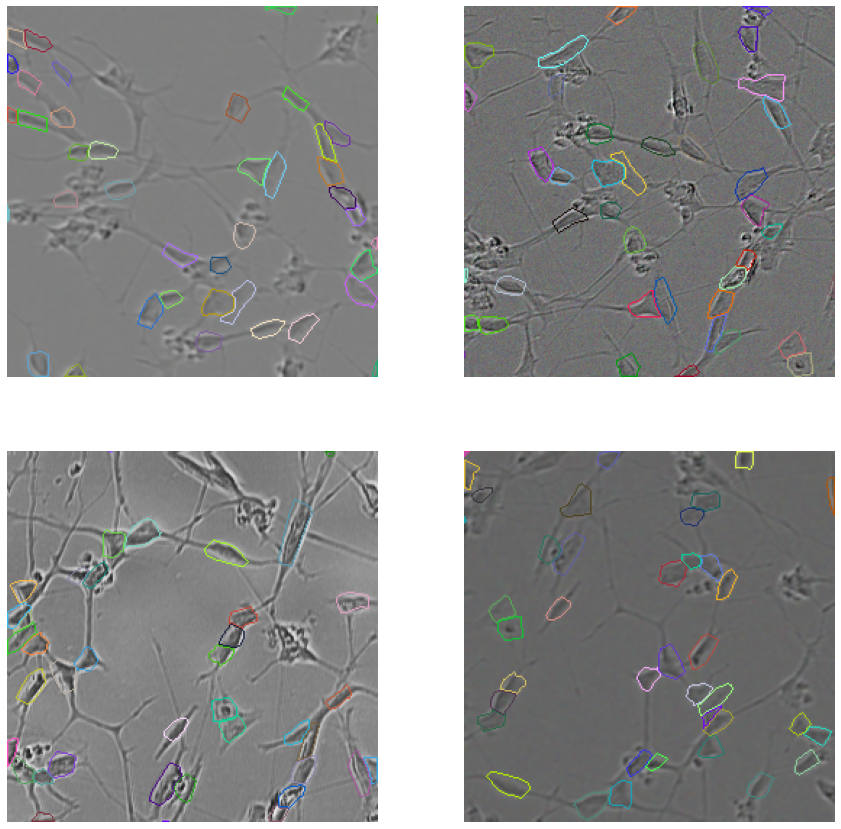

In [10]:
plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i + 1)
#     idx = np.random.choice(len(dataset))
    idx = 188
    img, masks = dataset[idx]

    try:
        img = img.numpy().transpose(1, 2, 0)
        mask = masks[0].numpy().astype(int)
        plot_sample(img, mask)
    except AttributeError:
        plot_sample(img, mask)

    plt.axis(False)
plt.show()

## Training

In [11]:
BATCH_SIZES = {
    "resnet18": 64,
    "resnet34": 32,
    "resnext50_32x4d": 32,
    "se_resnext50_32x4d": 32,
    "efficientnet-b0": 32,
    "efficientnet-b1": 32,
    "efficientnet-b2": 32,
    "efficientnet-b3": 16,
    "efficientnet-b4": 16,
    "efficientnet-b5": 16,
    "efficientnet-b6": 8,
}

In [12]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    size = 256
    size_val = 512
    use_tta = False
    width = 2

    # k-fold
    k = 5
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    encoder = "resnext50_32x4d"  # "resnet18" "resnext50_32x4d", "resnet34", "efficientnet-b5"
    decoder = "Unet"
    encoder_weights = "imagenet"
    num_classes = 3

    # Training
    loss = "BCEWithLogitsLoss"
    activation = "sigmoid"

    optimizer = "Adam"

    batch_size = BATCH_SIZES[encoder]
    val_bs = batch_size

    epochs = 50
    
    lr = 1e-3
    warmup_prop = 0.05

    first_epoch_eval = 0

In [13]:
DEBUG = True
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

preds, preds_instance, truths = k_fold(Config, log_folder=log_folder)


-------------   Fold 1 / 5  -------------

    -> 484 training images
    -> 122 validation images
    -> 31993267 trainable parameters

Epoch 01/50 	 lr=4.1e-04	 t=9s	loss=0.635	val_loss=2.134 	 dice=0.1846
Epoch 02/50 	 lr=8.1e-04	 t=8s	loss=0.432	val_loss=0.315 	 dice=0.3437
Epoch 03/50 	 lr=9.9e-04	 t=8s	loss=0.269	val_loss=0.251 	 dice=0.5373
Epoch 04/50 	 lr=9.7e-04	 t=8s	loss=0.179	val_loss=0.154 	 dice=0.6941
Epoch 05/50 	 lr=9.5e-04	 t=8s	loss=0.142	val_loss=0.133 	 dice=0.7003
Epoch 06/50 	 lr=9.3e-04	 t=8s	loss=0.121	val_loss=0.130 	 dice=0.6839
Epoch 07/50 	 lr=9.0e-04	 t=8s	loss=0.109	val_loss=0.098 	 dice=0.6942
Epoch 08/50 	 lr=8.8e-04	 t=8s	loss=0.109	val_loss=0.094 	 dice=0.6828
Epoch 09/50 	 lr=8.6e-04	 t=8s	loss=0.100	val_loss=0.086 	 dice=0.7204
Epoch 10/50 	 lr=8.4e-04	 t=8s	loss=0.094	val_loss=0.085 	 dice=0.7371
Epoch 11/50 	 lr=8.2e-04	 t=8s	loss=0.093	val_loss=0.082 	 dice=0.7225
Epoch 12/50 	 lr=8.0e-04	 t=8s	loss=0.088	val_loss=0.084 	 dice=0.7488
Epoch 13/5

## Viz

In [107]:
from utils.metrics import iou_map
from sklearn.model_selection import StratifiedKFold

In [108]:
from inference.post_process import *

In [109]:
config = Config

skf = StratifiedKFold(n_splits=config.k, shuffle=True, random_state=config.random_state)
splits = list(skf.split(X=df, y=df["cell_type"]))

all_preds, all_truths = [], []

for i, (train_idx, val_idx) in enumerate(splits):
    if i in config.selected_folds:
        df_val = df.iloc[val_idx].copy().reset_index(drop=True)
        dataset = SartoriusDataset(df_val,transforms=None)
        break

In [110]:
def preds_to_instance(preds, threshold=0.5):
    preds_instance = []
    for pred in preds:
        if pred.shape[0] == 1:
            image = (pred[0] > threshold).astype(int)

            distance = ndi.distance_transform_edt(image)

            coords = peak_local_max(distance, min_distance=10, labels=image, exclude_border=False)
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = ndi.label(mask)

            pred_instance = watershed(-distance, markers, mask=(pred[0] > threshold).astype(int))

        else:
            image = ((pred[0] * (1 - pred[1])) > threshold).astype(int)
            y_pred = measure.label(image, neighbors=8, background=0)
            props = measure.regionprops(y_pred)
            for i in range(len(props)):
                if props[i].area < 12:
                    y_pred[y_pred == i + 1] = 0
            y_pred = measure.label(y_pred, neighbors=8, background=0)

            mask = (pred[0] > threshold).astype(int)
            pred_instance = watershed(pred[0], y_pred, mask=mask, watershed_line=True)

        preds_instance.append(pred_instance)

    return preds_instance


In [111]:
for i, (pred, pred_i, truth) in enumerate(zip(preds, preds_instance, truths)):
    pred = [remove_padding(pred[i], truth) for i in range(len(pred))]

    preds_i = preds_to_instance(pred)
    
#     print(i)
    if i != 4:
        continue
    if i > 10:
        break
#         continue
        
    img, _ = dataset[i]
    
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis(False)
    plt.title('Image')
    plt.show()
    
    plt.figure(figsize=(15, 15))

    
    plot_sample((pred[0] > 0.4).astype(np.uint8) * 255, truth)
    plt.axis(False)
    plt.title('Image')
    plt.show()
    
    plt.figure(figsize=(15, 15))
    plot_sample(img, truth)
    plt.axis(False)
    plt.title('Truth')
    plt.show()
    
    plt.figure(figsize=(15, 15))
    plot_sample(img, pred_i)
    plt.axis(False)
    plt.title('Pred')
    plt.show()
    
    iou_map([truth], [pred_i], verbose=1)
    

#     break

TypeError: Only 2-D and 3-D images supported.